In [34]:
!pip install keras-buoy
import shutil
import matplotlib.pyplot as plt
from random import shuffle

import numpy as np
import os
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras_buoy.models import ResumableModel


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
###################################################################
# Arbeitsverzeichnisse festlegen (Google Colab)
###################################################################
# Lädt Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Gibt die Pfade zum Einlesen der Bilder und Labels an
srcpath_images = "/content/drive/My Drive/Testdaten/"
srcpath_label_infos = "/content/drive/My Drive/Wand_Label_Infos/"
srcpath_predict_images = "/content/drive/My Drive/Predict/"

# Gibt den Zielpfad an
destpath_dir = "/content/drive/My Drive/Training1/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [80]:
# Beta
%%writefile model_definition.txt
print(Test)

Overwriting model_definition.txt


In [ ]:
#Beta

import os
initial_count = 0
for path in os.listdir(srcpath_images):
    if os.path.isfile(os.path.join(srcpath_images, path)):
        initial_count += 1
print(initial_count)

In [ ]:
###################################################################
# Arbeitsverzeichnisse festlegen (Windows)
###################################################################
# Gibt die Pfade zum Einlesen der Bilder und Labels an
srcpath_images = "C:/Users/DanielWeller/Desktop/Testdaten/"
srcpath_label_infos = "C:/Users/DanielWeller/Desktop/Wand_Label_Infos/"
srcpath_predict_images = "C:/Users/DanielWeller/Desktop/Predict/"

# Gibt den Zielpfad an
destpath_dir = "C:/Users/DanielWeller/Desktop/Training1/"

In [84]:
###################################################################
# Parameter festlegen
###################################################################

# Wie heißt die CSV Datei in der die Labelinfos gespeichert sind
csv_name = "Wand_Label_Info7.csv"
# Spalte in der CSV Datei in der die Labelinfos gespeichert sind. Achtung counter beginnt mit 0
csv_spalte_labelinfo = 21

# Gibt die Pfade zum Zwischenspeichern der verwendeten Bilder an
# VORSICHT! ORDNER WERDEN BEIM START DES SKRIPTS GELÖSCHT/GELEERT!
destpath_train_images = destpath_dir + "Dataset/Trainingset/"
destpath_val_images = destpath_dir + "Dataset/Validationset/"
destpath_test_images = destpath_dir + "Dataset/Testset/"
# Gibt den Pfad zum speichern des trainierten Modells an
modelsavetemppath = destpath_dir + "models/temp/"
modelsavepathfinal = destpath_dir + "models/final/"


preprocesing_images = True
resizing_images = True
saving_images_to_dir = True
standardizing_images = False


###################################################################
# Werte für den Train-/Validation-/Testsplit
###################################################################
faktorTrainSplit = 0.8

###################################################################
# Werte für die Resize Funktion
###################################################################
# Zukünftige Maße für Querformat festlegen 
widthquer = 400
heightquer = 300
# Zukünftige Maße für Hochformat festlegen 
widthhoch = 300
heighthoch = 400


##################################################################################
# Methode in der die Parameter definiert werden, welche Bilder verwendet werden sollen
##################################################################################
def ImageIsInFilter(splittedfilename):
    # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
    if (
    # Prüft an Stelle 13 des Dateinamens auf das Flag "1". Damit werden nur Bilder geladen die mit dem Smartphone aufgenommen wurden
    (splittedfilename[13] == str(1)) and
    # Prüft an Stelle 14 des Dateinamens auf das Flag "1". Damit werden nur Bilder geladen die im Querformat vorliegen.
    (splittedfilename[14] == str(1)) and
    # Prüft an Stelle 15 des Dateinamens auf das Flag "1", "2", "3" und "4". Damit werden nur Bilder geladen die ohne, mit rotem, einem Aruco oder drei Aruco Sticker aufgenommen wurden.
    ( (splittedfilename[15] == str(1)) or (splittedfilename[15] == str(2)) or (splittedfilename[15] == str(3)) or (splittedfilename[15] == str(4)) )
    ):
        return True
    return False

In [86]:
###################################################################
# Einlesen der Daten (Bilder und Label)
###################################################################

# Hilfslisten und Variablen zur Verteilung des Train-/Testsplits
waende_alle = []
waende_train = []
waende_val = []
waende_test = []
# Arrays für die Images des Train- und Testsplits
x_train_material = []
x_val_material = []
x_test_material = []
# Arrays für die Labels des Train- und Testsplits
y_train_material = []
y_val_material = []
y_test_material = []
# Hilfsarray um die Dateinamen aller verwendeten Bilder zwischenzuspeichern
images_train_filenames = []
images_val_filenames = []
images_test_filenames = []
images_all_filenames = []



#################################################################################
# Leert die Ordner der Train- und Testbilder
#################################################################################
if saving_images_to_dir:
  if os.path.exists(destpath_train_images):
      shutil.rmtree(destpath_train_images, ignore_errors = False) 
  os.makedirs(destpath_train_images)
  if os.path.exists(destpath_val_images):
      shutil.rmtree(destpath_val_images, ignore_errors = False) 
  os.makedirs(destpath_val_images)
  if os.path.exists(destpath_test_images):
      shutil.rmtree(destpath_test_images, ignore_errors = False) 
  os.makedirs(destpath_test_images)



##################################################################################
# Wand-Label-Info-CSV in NP Array einlesen
##################################################################################
# eventueller Parameter: usecols = (0,1,2,3,4,5,6)
# eventueller Parameter: dtype="int" 

with open(str(srcpath_label_infos)+str(csv_name)) as wand_label_info_file:
    wand_label_info = np.loadtxt(wand_label_info_file, delimiter=";", dtype="int")
#print(wand_label_info)





##################################################################################
# Baustellen und Wand ID aus Dateinamen laden um Train/Testsplit auf Wandebene vorzubereiten
##################################################################################
for filename in os.listdir(srcpath_images):
    # Trennt den Filename in den reinen Filename und Extension
    filenameshort, extension = os.path.splitext(filename)
    # Prüft ob Datei .jpg ist
    if extension == ".jpg":
        # Splitted den Dateinamen mit dem Trennoperator "_" und speichert den Inhalt in eine Liste
        splittedfilename = filenameshort.split("_")
        # Speichert die Baustellennummer und Wandnummer zwischen
        img_baustellenID = splittedfilename[1]
        img_wandID = splittedfilename[2]
        img_baustellenUndWandID = img_baustellenID+"_"+img_wandID
        # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
        if (ImageIsInFilter(splittedfilename)):
            if img_baustellenUndWandID not in waende_alle:
                waende_alle.append(img_baustellenUndWandID)              
print("Anzahl aller verwendeten Wände/Szenen: "+str(len(waende_alle)))
# Bestimmt die Anzahl der Wände für den Trainingssplit. Dafür wird der vorherig definierte Faktor verwendet
waende_train, waende_uebrig = train_test_split(waende_alle, train_size=faktorTrainSplit, random_state=42)
waende_val, waende_test = train_test_split(waende_uebrig, test_size = 0.05, random_state=42)

print("Anzahl der Wände/Szenen für das Trainingset: "+str(len(waende_train)))
print("Anzahl der Wände/Szenen für das Validationset: "+str(len(waende_val)))
print("Anzahl der Wände/Szenen für das Testset: "+str(len(waende_test)))




##################################################################################
# gewünschte Bilder werden bearbeitet und dem Train- oder Testsplit hinzugefügt
##################################################################################
for filename in os.listdir(srcpath_images):
    # Trennt den Filename in den reinen Filename und Extension
    filenameshort, extension = os.path.splitext(filename)
    # Prüft ob Datei .jpg ist
    if extension == ".jpg":
        # Splitted den Dateinamen mit dem Trennoperator "_" und speichert den Inhalt in eine Liste
        splittedfilename = filenameshort.split("_")
        # Speichert die Baustellennummer und Wandnummer zwischen
        img_baustellenID = splittedfilename[1]
        img_wandID = splittedfilename[2]
        img_baustellenUndWandID = img_baustellenID+"_"+img_wandID
        # Welche Images sollen aus dem vorher angegebenen Src-Ordner verwendet werden. Gefiltert wird nach den Flags im Dateinamen (siehe Methode "ImageIsInFilter")
        if (ImageIsInFilter(splittedfilename)):
            # Gefilterte Bilder/Images laden
            img = cv2.imread(os.path.join(srcpath_images,filename))


  
 
            ###################################################################################
            # Preprocessing der Bilder1
            ###################################################################################
            if preprocesing_images:
              imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Bild wird schwarz weiß
              # print(f"Shape imgGray: {imgGray.shape}")
              imgBlur=cv2.GaussianBlur(imgGray,(5,5),1) #Kernel 5*5
              # print(f"Shape imgBlur: {imgGray.shape}")
              # Canny Filter: Thr = For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded.
              imgCanny=cv2.Canny(imgBlur, 40, 40) #Cannyfilter (25, 25 guter Wert, wenn nur Canny)
              # print(f"Shape imgCanny: {imgCanny.shape}")
              kernel= np.ones((5,5)) #Neuer Kernel für Dilate (5*5 groß)
              imgDial = cv2.dilate(imgCanny,kernel,iterations=2) #Erweitert das Bild (verstärkt)
              # print(f"Shape imgDial: {imgDial.shape}")
              imgThre=cv2.erode(imgDial,kernel,iterations=1) #Verfeinert das Bild (verwässert)
              # print(f"Shape imgThre: {imgThre.shape}")
              img = imgThre


            ##################################################################################
            # Resizing der Bilder
            ##################################################################################
            if resizing_images:
              # Resize der Bilder auf neue Maße wie zu Beginn angegeben
              # Prüft ob Bild Querformat ist
              if splittedfilename[14] == str(1):
                  dim = (widthquer, heightquer)
              # Prüft ob Bild Hochformat ist
              elif splittedfilename[14] == str(2):
                  dim = (widthhoch, heighthoch)
              # Resize mit neuen Dimensionen
              resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
              img = resized



            ###################################################################################
            # Speichern der Bilder in die zuvor angegebenen Zielordner  
            ###################################################################################
            if saving_images_to_dir:
              if img_baustellenUndWandID in waende_train:
                  cv2.imwrite(os.path.join(destpath_train_images , filenameshort+'.jpg'),img)
              elif img_baustellenUndWandID in waende_val:
                  cv2.imwrite(os.path.join(destpath_val_images , filenameshort+'.jpg'),img)
              else:   
                  cv2.imwrite(os.path.join(destpath_test_images , filenameshort+'.jpg'),img)



            ###################################################################################
            # Preprocessing der Bilder2
            ###################################################################################
            if preprocesing_images:
              # print(f"Shape before new dimension: {img.shape}")
              img = tf.expand_dims(img,axis=2)
              # print(f"Shape after new dimension: {img.shape}")



            ##################################################################################
            # Speichern der Bilder und der zugehörigen Labels in die Arrays des Train- und Testsets  
            ################################################################################## 
            # Prüft ob das Bild zu den Traingswänden gehört
            if img_baustellenUndWandID in waende_train:
                x_train_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen in der CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_train_material" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in der CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_train_material" hinzu
                        y_train_material.append(np.array(wand_label_info[i][csv_spalte_labelinfo]))
                # Den Dateinamen des gefilterten Traings-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_train_filenames.append(np.array(filenameshort))
            # Prüft ob das Bild zu den Validationwänden gehört
            elif img_baustellenUndWandID in waende_val:
                x_val_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen in der CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_val_material" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in der CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_train_material" hinzu
                        y_val_material.append(np.array(wand_label_info[i][csv_spalte_labelinfo]))
                # Den Dateinamen des gefilterten Traings-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_val_filenames.append(np.array(filenameshort))
            # Wenn das Bild nicht zu den Trainings- oder Validationswänden gehört, gehört es zu den Testwänden          
            else:
                x_test_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen im Array aus der eingelesen CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_test_material" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in dem Array der eingelesen CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_test_material" hinzu
                        y_test_material.append(np.array(wand_label_info[i][csv_spalte_labelinfo]))
                # Den Dateinamen des gefilterten Test-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_test_filenames.append(np.array(filenameshort))
            # Den Dateinamen des gefilterten Images in einem Array speichern in dem alle verwendeten Dateinamen gespeichert werden. Für spätere Kontrolle nützlich
            images_all_filenames.append(np.array(filenameshort))


##################################################################################
# Konvertierung in NP Arrays
################################################################################## 
images_train_filename = np.array(images_train_filenames)
images_val_filename = np.array(images_val_filenames)
images_test_filenames = np.array(images_test_filenames)
images_all_filenames = np.array(images_all_filenames)
x_train_material = np.array(x_train_material)
y_train_material = np.array(y_train_material)
x_val_material = np.array(x_val_material)
y_val_material = np.array(y_val_material)
x_test_material = np.array(x_test_material)
y_test_material = np.array(y_test_material)

##################################################################################
# Ausgabe der Werte auf der Konsole
################################################################################## 
print()
print("Anzahl aller verwendeter Bilder: "+str(len(images_all_filenames)))
print()
print("Traingset:")
print("Anzahl der im Array x_train_material gespeicherten Bilder: "+str(len(x_train_material)))
print("Anzahl der im Array y_train_material gespeicherten Labels: "+str(len(y_train_material)))
print("y_train_material Min: "+str(np.amin(y_train_material)))
print("y_train_material Max: "+str(np.amax(y_train_material)))
print("y_train_material Mean: "+str(np.mean(y_train_material)))
print()
print("Validationset:")
print("Anzahl der im Array x_val_material gespeicherten Bilder: "+str(len(x_val_material)))
print("Anzahl der im Array y_val_material gespeicherten Labels: "+str(len(y_val_material)))
print("y_val_material Min: "+str(np.amin(y_val_material)))
print("y_val_material Max: "+str(np.amax(y_val_material)))
print("y_val_material Mean: "+str(np.mean(y_val_material)))
print()
print("Testset:")
print("Anzahl der im Array x_test_material gespeicherten Bilder: "+str(len(x_test_material)))
print("Anzahl der im Array y_test_material gespeicherten Labels: "+str(len(y_test_material)))
print("y_test_material Min: "+str(np.amin(y_test_material)))
print("y_test_material Max: "+str(np.amax(y_test_material)))
print("y_test_material Mean: "+str(np.mean(y_test_material)))




Anzahl aller verwendeten Wände/Szenen: 114
Anzahl der Wände/Szenen für das Trainingset: 91
Anzahl der Wände/Szenen für das Validationset: 21
Anzahl der Wände/Szenen für das Testset: 2

Anzahl aller verwendeter Bilder: 590

Traingset:
Anzahl der im Array x_train_material gespeicherten Bilder: 487
Anzahl der im Array y_train_material gespeicherten Labels: 487
y_train_material Min: 2069
y_train_material Max: 14992
y_train_material Mean: 6385.780287474333

Validationset:
Anzahl der im Array x_val_material gespeicherten Bilder: 91
Anzahl der im Array y_val_material gespeicherten Labels: 91
y_val_material Min: 1688
y_val_material Max: 14992
y_val_material Mean: 7976.978021978022

Testset:
Anzahl der im Array x_test_material gespeicherten Bilder: 12
Anzahl der im Array y_test_material gespeicherten Labels: 12
y_test_material Min: 5206
y_test_material Max: 5986
y_test_material Mean: 5661.0


In [90]:
##################################################################################
# Definieren des Modells
##################################################################################  

if preprocesing_images:
  # Wenn Preproccessng genutzt wird ist das Bild schwarz/weiß. Dadurch hat das Bild nur eine Tiefe von einer Schicht.
  image_layer = 1
else:
  # Falls kein Preproccessing genutzt wird ist das Bild in Farbe. Dadurch hat das Bild eine Tiefe von drei Schichten.
  image_layer = 3


material_model = Sequential([

    Conv2D(128, kernel_size=3, activation='relu', input_shape=(300, 400, image_layer)),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D(128, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D(256, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D (512, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Flatten(),

    Dropout(0.5),

    Dense(512, activation='relu'),

    Dense(1, activation='linear', name='material')
])

material_model.compile(
optimizer='adam',
loss='mse',
metrics =['mae']
)


In [98]:
##################################################################################
# Printen des Modells
################################################################################## 
print(material_model.summary ())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 398, 128)     1280      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 198, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 146, 196, 128)     147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 72, 97, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 70, 95, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 47, 256)     

In [92]:
##################################################################################
# Training des Modells
################################################################################## 

# Packt ein Wrapper um das Modell um es regelmäßig abzuspeichern. Dabei wird auch die History unter dem Dateipfad gespeichert
resumable_model = ResumableModel(material_model, save_every_epochs=50, to_path= (modelsavetemppath+"material_model_temp.h5"))

# Training des Modells
history = resumable_model.fit(x=x_train_material, y=y_train_material, validation_data=(x_val_material, y_val_material), batch_size=32, shuffle=True, epochs=100)

# Laden der letzten Version des Modells um damit später zu evaluieren
material_model = tf.keras.models.load_model(modelsavetemppath+"material_model_temp.h5")
print("final trainiertes Modell geladen")


Epoch 1/100
 6/16 [==========>...................] - ETA: 1s - loss: 110595200.0000 - mae: 8429.7646

16/16 [==============================] - 4s 162ms/step - loss: 73583880.0000 - mae: 7062.0376 - val_loss: 65626808.0000 - val_mae: 6905.9580
Epoch 2/100
16/16 [==============================] - 2s 138ms/step - loss: 19464334.0000 - mae: 3299.0723 - val_loss: 18514762.0000 - val_mae: 3690.2068
Epoch 3/100
16/16 [==============================] - 2s 138ms/step - loss: 12261884.0000 - mae: 2764.4048 - val_loss: 16321439.0000 - val_mae: 3589.2585
Epoch 4/100
16/16 [==============================] - 2s 144ms/step - loss: 12107888.0000 - mae: 2749.2864 - val_loss: 18866196.0000 - val_mae: 3719.6064
Epoch 5/100
16/16 [==============================] - 2s 148ms/step - loss: 13003496.0000 - mae: 2801.5254 - val_loss: 15765462.0000 - val_mae: 3569.5903
Epoch 6/100
16/16 [==============================] - 2s 144ms/step - loss: 12000695.0000 - mae: 2729.3308 - val_loss: 15863020.0000 - val_mae: 3569.8667
Epoch 7/100
16/16 [==============================] - 2s 141ms/step - loss: 11444423.0000 - mae

In [8]:
##################################################################################
# Finales speichern des Modells
################################################################################## 
material_model.save(modelsavepathfinal + "material_model_final.h5")
print("final trainiertes Modell gespeichert")

final trainiertes Modell gespeichert


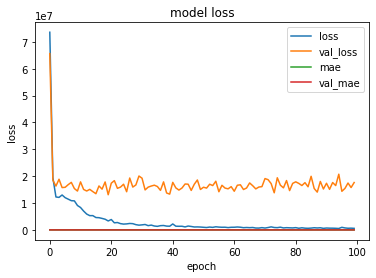

In [97]:
##################################################################################
# Plotten der Trainings-History des Modells
################################################################################## 

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.plot(history['mae'])
plt.plot(history['val_mae'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'mae', 'val_mae'], loc='upper right')
plt.show()

In [93]:
##################################################################################
# Evaluieren des Modells (Allgemein)
################################################################################## 
print("Evaluation Validationset:")
val_material = material_model.evaluate(x_val_material, y_val_material)
print("Evaluation Testset:")
test_material = material_model.evaluate(x_test_material, y_test_material)


Evaluation Validationset:
3/3 [==============================] - 0s 55ms/step - loss: 17639228.0000 - mae: 3431.5955
Evaluation Testset:
1/1 [==============================] - 0s 115ms/step - loss: 1228834.1250 - mae: 919.2734


In [95]:
##################################################################################
# Evaluieren des Modells (einzeln per Predict) (Trainingset)
################################################################################## 

# Trainingset
print()
print("Trainingset: ")
i = 0
while i < len(x_train_material):
  print("Bild: "+str(images_train_filenames[i]))
  x = x_train_material[i]
  x = tf.expand_dims(x,axis=0)
  result = material_model.predict(x)
  print("Vorhergesagter Materialbedarf in g: "+str(result[0][0]))
  print("Tatsächlicher Materialbedarf in g: "+str(y_train_material[i]))
  print()
  i += 1


Trainingset: 
Bild: 1_1_1_21_1_1_1_1_1_1_1_1_1_1_1_1
Vorhergesagter Materialbedarf in g: 6609.415
Tatsächlicher Materialbedarf in g: 6801

Bild: 1_1_1_22_1_1_1_1_1_1_1_1_1_1_1_1
Vorhergesagter Materialbedarf in g: 6432.33
Tatsächlicher Materialbedarf in g: 6801

Bild: 1_1_1_23_1_1_1_1_1_1_1_1_1_1_1_1
Vorhergesagter Materialbedarf in g: 6258.6787
Tatsächlicher Materialbedarf in g: 6801

Bild: 1_1_1_24_1_1_1_1_1_1_1_1_1_1_1_1
Vorhergesagter Materialbedarf in g: 6389.6084
Tatsächlicher Materialbedarf in g: 6801

Bild: 1_1_2_18_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 4882.4995
Tatsächlicher Materialbedarf in g: 4738

Bild: 1_1_2_19_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 5155.938
Tatsächlicher Materialbedarf in g: 4738

Bild: 1_1_2_20_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 5188.7285
Tatsächlicher Materialbedarf in g: 4738

Bild: 1_1_2_21_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 4912.04
Tatsächlicher Materialbe

In [96]:
##################################################################################
# Evaluieren des Modells (einzeln per Predict) (Validation- und Testset)
################################################################################## 

# Validationset
print()
print("Validationset: ")
i = 0
while i < len(x_val_material):
  print("Bild: "+str(images_val_filenames[i]))
  x = x_val_material[i]
  x = tf.expand_dims(x,axis=0)
  result = material_model.predict(x)
  print("Vorhergesagter Materialbedarf in g: "+str(result[0][0]))
  print("Tatsächlicher Materialbedarf in g: "+str(y_val_material[i]))
  print()
  i = i + 1

# Testset
print()
print()
print()
print("Testset: ")
i = 0
while i < len(x_test_material):
  print("Bild: "+str(images_test_filenames[i]))
  x = x_test_material[i]
  x = tf.expand_dims(x,axis=0)
  result = material_model.predict(x)
  print("Vorhergesagter Materialbedarf in g: "+str(result[0][0]))
  print("Tatsächlicher Materialbedarf in g: "+str(y_test_material[i]))
  print()
  i = i + 1


Validationset: 
Bild: 1_1_4_14_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 5013.522
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_15_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 4826.7334
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_16_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 5971.003
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_17_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 5225.587
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_18_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 6238.157
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_19_1_1_1_1_1_1_1_1_1_1_1_2
Vorhergesagter Materialbedarf in g: 6036.199
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_20_1_1_1_1_1_1_1_1_1_1_1_1
Vorhergesagter Materialbedarf in g: 4726.235
Tatsächlicher Materialbedarf in g: 4680

Bild: 1_1_4_21_1_1_1_1_1_1_1_1_1_1_1_1
Vorhergesagter Materialbedarf in g: 5160.1797
Tatsächlicher Material

In [13]:
##################################################################################
# Predict
################################################################################## 

imgToPredict = cv2.imread(srcpath_predict_images+"flugzeug.jpg")
imgToPredict = cv2.resize(imgToPredict, (400, 300), interpolation = cv2.INTER_AREA)
#print(f"Shape before new dimension: {imgToPredict.shape}")
imgToPredict = tf.expand_dims(imgToPredict,axis=0)
#print(f"Shape after new dimension: {imgToPredict.shape}")
result = material_model.predict(imgToPredict)
print("Vorhersage Flugzeugbild: "+str(result))

imgToPredict = cv2.imread(srcpath_predict_images+"auto.jpg")
imgToPredict = cv2.resize(imgToPredict, (400, 300), interpolation = cv2.INTER_AREA)
#print(f"Shape before new dimension: {imgToPredict.shape}")
imgToPredict = tf.expand_dims(imgToPredict,axis=0)
#print(f"Shape after new dimension: {imgToPredict.shape}")
result = material_model.predict(imgToPredict)
print("Vorhersage Autobild: "+str(result))

imgToPredict = cv2.imread(srcpath_predict_images+"gipswand.jpg")
imgToPredict = cv2.resize(imgToPredict, (400, 300), interpolation = cv2.INTER_AREA)
#print(f"Shape before new dimension: {imgToPredict.shape}")
imgToPredict = tf.expand_dims(imgToPredict,axis=0)
#print(f"Shape after new dimension: {imgToPredict.shape}")
result = material_model.predict(imgToPredict)
print("Vorhersage Gipswandbild (Baustelle2 Wand10): "+str(result)+" (Tatsächlicher Materialbedarf = 6627g)")


Vorhersage Flugzeugbild: [[3787.275]]
Vorhersage Autobild: [[4927.784]]
Vorhersage Gipswandbild (Baustelle2 Wand10): [[6433.505]] (Tatsächlicher Materialbedarf = 6627g)
